# Aggregated model - class - test set: 3 domain features
# Table of contents 
1. [Linear Regression](#LinearRegression)
2. [MLP (Dense)](#MLP)
3. [AE combined latent](#AE_combined)
4. [AE OTU latent](#AE_latentOTU)

In [1]:
from data import *
from train_2 import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures( \
        metadata_names=['age','Temperature','Precipitation3Days'],
        otu_filename='data/Aggregated/otu_table_Class.csv',
        metadata_filename='data/Aggregated/metadata_table_all_80.csv')

In [3]:
print(df_microbioma_train.shape[1])
print(df_microbioma_test.shape)

45
(373, 45)


In [4]:
print('TRAIN:')
print('age:' + str(df_domain_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_test.loc[:,'Temperature'].mean()))

TRAIN:
age:9.131498470948012
rain:0.4424182545283462
Tª:69.01096212655845
TEST:
age:9.091152815013405
rain:0.4129758713136729
Tª:69.06434316353888


### Get numpy objects

In [5]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

# 1. Linear regression <a name="LinearRegression"></a>

In [6]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [7]:
def model_fn():
    m = model(shape_in=data_domain_train.shape[1],
              shape_out=data_microbioma_train.shape[1],
              output_transform=None)
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [8]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>97</b></p>

<b>loss</b>: 2.2338 (min: 2.2086, max: 2.2551)

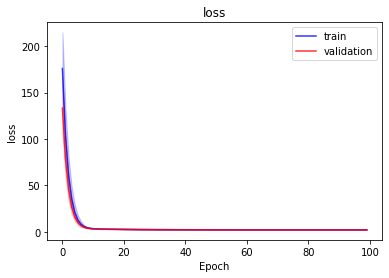

<b>domain_BrayCurtis</b>: 0.2942 (min: 0.2927, max: 0.2959)

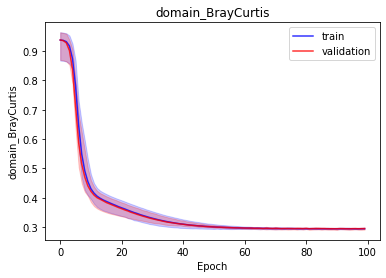

<b>domain_pearson_corr</b>: nan (min: nan, max: nan)

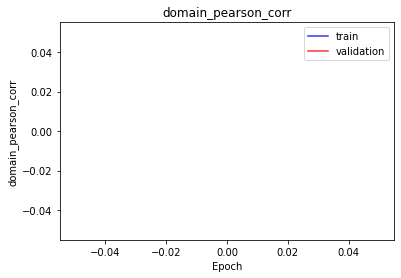

<b>domain_jensen_shannon_divergence</b>: 0.3935 (min: 0.3864, max: 0.3994)

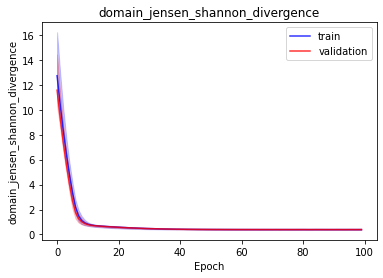

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 2.233765290253767 | 2.2086262297749486 | 2.255143128363955 |
| domain_BrayCurtis | 0.2941688895225525 | 0.2926941514015198 | 0.29590195417404175 |
| domain_pearson_corr | nan | nan | nan |
| domain_jensen_shannon_divergence | 0.3934648633003235 | 0.38642027974128723 | 0.3993947505950928 |


[('best_lost_epoch', 97),
 ('val_loss', [2.23650723355157, 2.1446928467069353, 2.354284031050546]),
 ('val_domain_BrayCurtis', [0.2938818, 0.29077658, 0.2976373]),
 ('val_domain_pearson_corr', [nan, nan, nan]),
 ('val_domain_jensen_shannon_divergence',
  [0.39334044, 0.36493295, 0.41489783])]

In [9]:
print_results(results)

In [10]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_linear_regresion_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2982586920261383 | 0.2968563139438629 | 0.29970699548721313 |
| pearson_corr | nan | nan | nan |
| jensen_shannon_divergence | 0.36907070875167847 | 0.3664487302303314 | 0.37031036615371704 |


# 2. MLP (Dense) <a name="MLP"></a>

In [11]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [12]:
def model_fn():
    m = model(shape_in=data_domain_train.shape[1],
              shape_out=data_microbioma_train.shape[1],
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.01),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [13]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>12</b></p>

<b>loss</b>: 2.3123 (min: 2.2687, max: 2.3543)

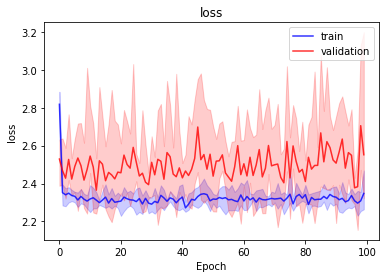

<b>domain_BrayCurtis</b>: 0.2978 (min: 0.2941, max: 0.3047)

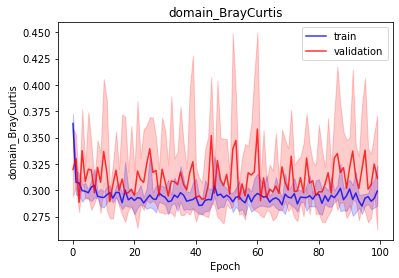

<b>domain_pearson_corr</b>: nan (min: nan, max: nan)

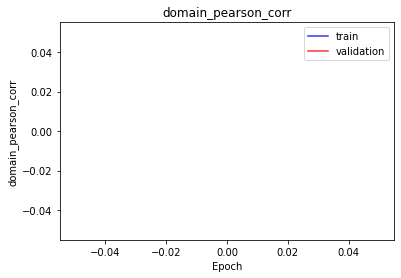

<b>domain_jensen_shannon_divergence</b>: 0.4091 (min: 0.4000, max: 0.4192)

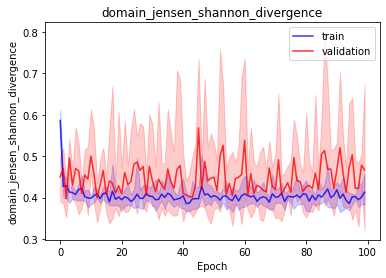

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 2.312283805430776 | 2.2687388578256207 | 2.354332895559423 |
| domain_BrayCurtis | 0.2978435158729553 | 0.29410088062286377 | 0.3046569228172302 |
| domain_pearson_corr | nan | nan | nan |
| domain_jensen_shannon_divergence | 0.4090794622898102 | 0.400007963180542 | 0.4191584289073944 |


[('best_lost_epoch', 12),
 ('val_loss', [2.3647505402565003, 2.2410547052110945, 2.5329008272715976]),
 ('val_domain_BrayCurtis', [0.28913146, 0.27312648, 0.29989117]),
 ('val_domain_pearson_corr', [nan, nan, nan]),
 ('val_domain_jensen_shannon_divergence',
  [0.39989537, 0.34015155, 0.43521026])]

In [14]:
print_results(results)

In [15]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_MLP_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.3161306381225586 | 0.26640892028808594 | 0.38602906465530396 |
| pearson_corr | nan | nan | nan |
| jensen_shannon_divergence | 0.4372935891151428 | 0.3198085427284241 | 0.655019998550415 |


# 3. Auto-encoder combined latent <a name="AE_combined"></a>

In [16]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [17]:
#df_microbioma_train, df_microbioma_test, _, _, \
#df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
#    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [18]:
#data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
#data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
#data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
#data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [19]:
data_microbioma_train.shape

(4251, 45)

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 5 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>96</b></p>

<b>loss</b>: 0.3606 (min: 0.3532, max: 0.3723)

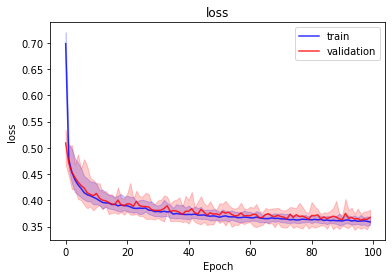

<b>bioma_loss</b>: 0.0808 (min: 0.0762, max: 0.0876)

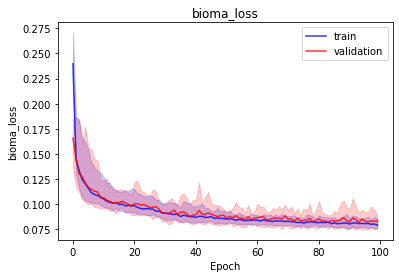

<b>domain_loss</b>: 0.2649 (min: 0.2631, max: 0.2663)

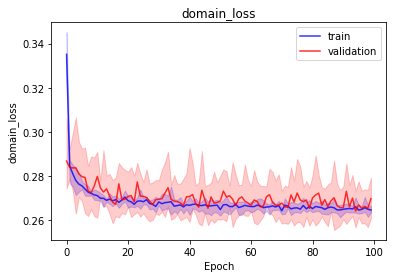

<b>latent_loss</b>: 0.0152 (min: 0.0128, max: 0.0199)

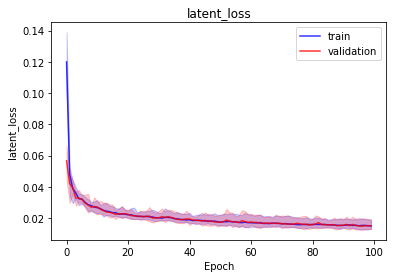

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

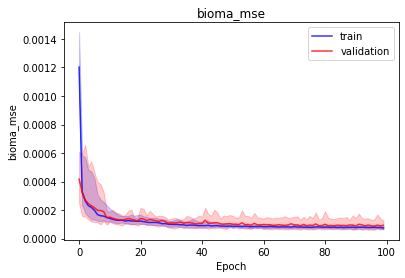

<b>bioma_mae</b>: 0.0035 (min: 0.0033, max: 0.0038)

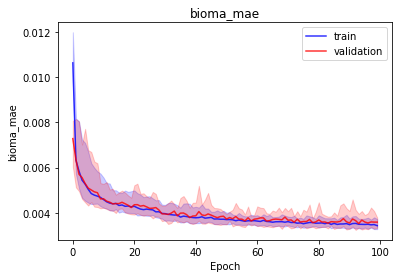

<b>bioma_mape</b>: 20493.8379 (min: 19400.0645, max: 21315.8242)

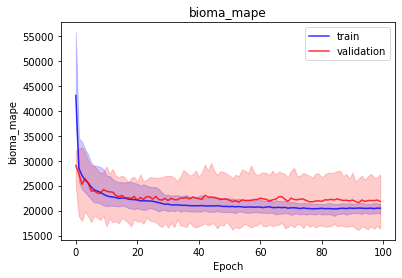

<b>bioma_BrayCurtis</b>: 0.0807 (min: 0.0761, max: 0.0870)

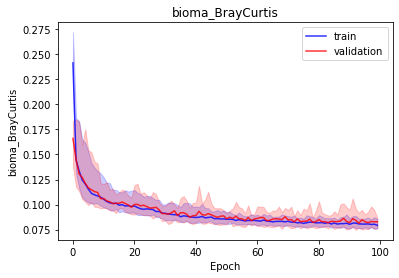

<b>bioma_pearson_corr</b>: nan (min: nan, max: nan)

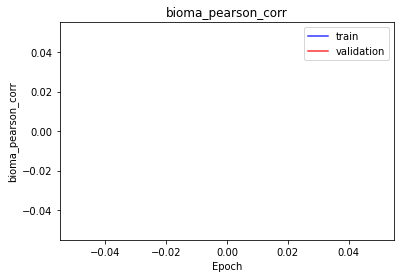

<b>bioma_jensen_shannon_divergence</b>: 0.0857 (min: 0.0801, max: 0.0928)

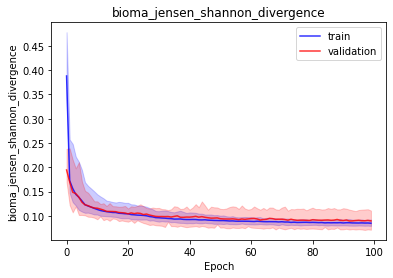

<b>domain_mse</b>: 0.0018 (min: 0.0018, max: 0.0019)

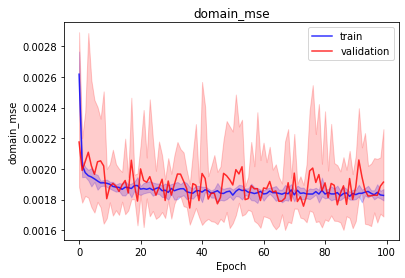

<b>domain_mae</b>: 0.0117 (min: 0.0116, max: 0.0117)

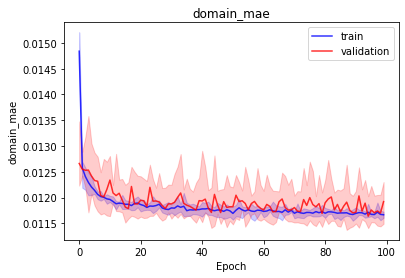

<b>domain_mape</b>: 31893.3027 (min: 29955.2910, max: 34548.2852)

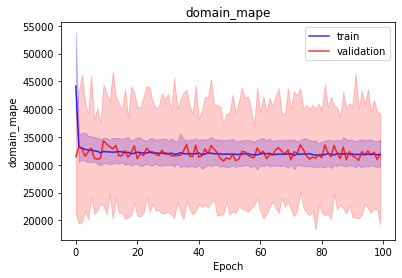

<b>domain_BrayCurtis</b>: 0.2647 (min: 0.2631, max: 0.2657)

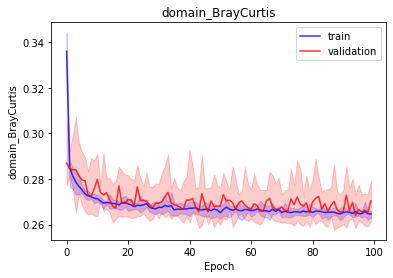

<b>domain_pearson_corr</b>: nan (min: nan, max: nan)

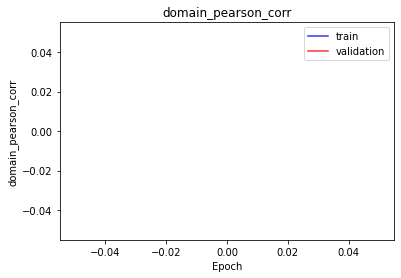

<b>domain_jensen_shannon_divergence</b>: 0.3515 (min: 0.3445, max: 0.3584)

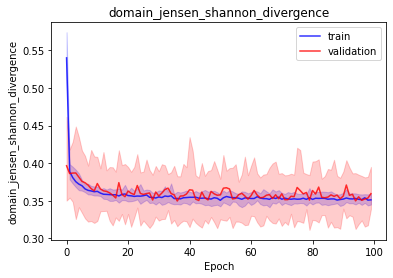

<b>latent_mae</b>: 0.0152 (min: 0.0129, max: 0.0198)

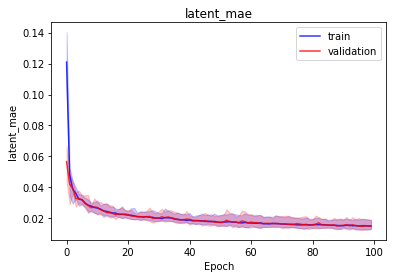

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.3605806559266801 | 0.35317280528405876 | 0.372306353484883 |
| bioma_loss | 0.08075863122940063 | 0.07618644833564758 | 0.08757609128952026 |
| domain_loss | 0.26487818360328674 | 0.26312270760536194 | 0.2662852704524994 |
| latent_loss | 0.015223994851112366 | 0.01283059548586607 | 0.019929049536585808 |
| bioma_mse | 7.87985700299032e-05 | 6.857477274024859e-05 | 9.552137635182589e-05 |
| bioma_mae | 0.0034906945656985044 | 0.0032906823325902224 | 0.0037809053901582956 |
| bioma_mape | 20493.837890625 | 19400.064453125 | 21315.82421875 |
| bioma_BrayCurtis | 0.08065581321716309 | 0.07609669119119644 | 0.0869794711470604 |
| bioma_pearson_corr | nan | nan | nan |
| bioma_jensen_shannon_divergence | 0.08572667092084885 | 0.0801258236169815 | 0.09278636425733566 |
| domain_mse | 0.0018318040529266 | 0.001801921520382166 | 0.001860615680925548 |
| domain_mae | 0.011672071181237698 | 0.01160009577870369 | 0.011723395437002182 |
| domain_mape | 31893.302734375 | 29955.291015625 | 34548.28515625 |
| domain_BrayCurtis | 0.2647326588630676 | 0.26305434107780457 | 0.26568150520324707 |
| domain_pearson_corr | nan | nan | nan |
| domain_jensen_shannon_divergence | 0.3514830470085144 | 0.34451279044151306 | 0.358419805765152 |
| latent_mae | 0.015192176215350628 | 0.012897782027721405 | 0.019834453240036964 |


*************

In [20]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=5, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],                                   
                        #layers=[128],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=data_domain_train,
                        show_results=True, 
                        device='/CPU:0')

In [21]:
predictions = test_model_cv_predictions(models, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_aggregated_phylum_testSet_AE_combinedLatent_5CV_3var.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2609514594078064 | 0.2609514594078064 | 0.2609514594078064 |
| pearson_corr | nan | nan | nan |
| jensen_shannon_divergence | 0.3096266984939575 | 0.3096266984939575 | 0.3096266984939575 |


# 4. Auto-encoder OTU latent <a name="AE_latentOTU"></a>

In [22]:
#from train_2 import *

### Get microbioma train data and numpy train objects

In [23]:
#df_microbioma_train, df_microbioma_test, _, _, \
#df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
#    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [24]:
#data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
#data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
#data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
#data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [25]:
data_microbioma_train.shape

(4251, 45)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>76</b></p>

<b>loss</b>: 0.0572 (min: 0.0572, max: 0.0572)

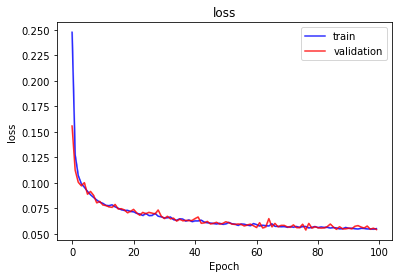

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

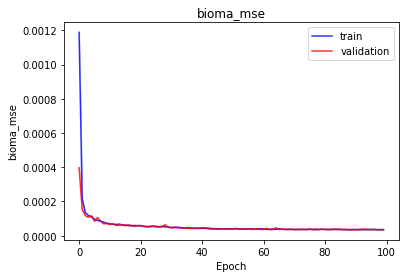

<b>bioma_mae</b>: 0.0024 (min: 0.0024, max: 0.0024)

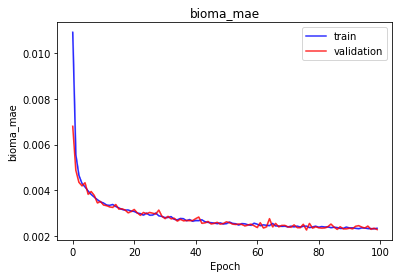

<b>bioma_mape</b>: 18822.0273 (min: 18822.0273, max: 18822.0273)

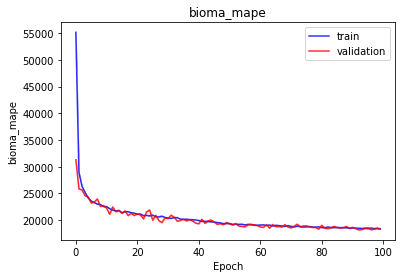

<b>bioma_BrayCurtis</b>: 0.0572 (min: 0.0572, max: 0.0572)

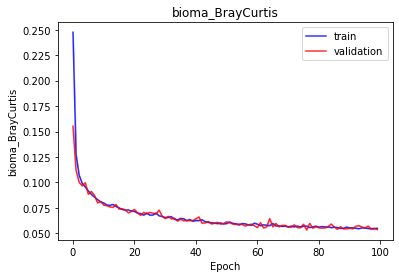

<b>bioma_pearson_corr</b>: nan (min: nan, max: nan)

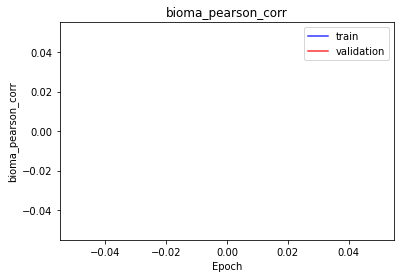

<b>bioma_jensen_shannon_divergence</b>: 0.0698 (min: 0.0698, max: 0.0698)

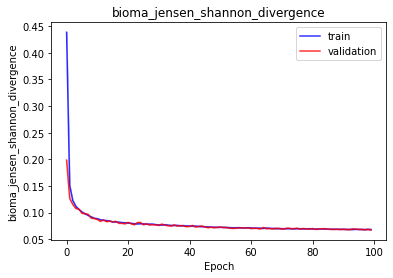

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.057169455072685456 | 0.057169455072685456 | 0.057169455072685456 |
| bioma_mse | 3.799890691880137e-05 | 3.799890691880137e-05 | 3.799890691880137e-05 |
| bioma_mae | 0.00244683469645679 | 0.00244683469645679 | 0.00244683469645679 |
| bioma_mape | 18822.02734375 | 18822.02734375 | 18822.02734375 |
| bioma_BrayCurtis | 0.05716945230960846 | 0.05716945230960846 | 0.05716945230960846 |
| bioma_pearson_corr | nan | nan | nan |
| bioma_jensen_shannon_divergence | 0.06982003897428513 | 0.06982003897428513 | 0.06982003897428513 |


*************

In [26]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        #layers=[128],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in domain->latent model

In [27]:
model, encoder, _ ,decoder = models[0]

In [28]:
df_domain_train.shape

(4251, 3)

### To predict latent space for samples in domain->latent model

In [29]:
latent_train = encoder.predict(data_microbioma_train)
latent_test = encoder.predict(data_microbioma_test)

### To build model to predict latent space 

In [30]:
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [31]:
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                            latent_train,
                            latent_train,
                            data_domain_train,
                            data_domain_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

In [32]:
print_results_noEnsemble(result_latent)

<p>Best iteration: <b>75</b></p>

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.028579605722828815 | 0.02771090502955652 | 0.04223863144412416 |
| domain_mean_squared_error | 0.028579607605934143 | 0.02771090902388096 | 0.04223863035440445 |


In [33]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_latent, latent_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_domain-latent_AE_OTUlatent_3var.txt)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.026569973677396774 | 9.267711043037252e-09 | 0.6096680760383606 |


### Domain -> latent -> microbiome. Test set

In [34]:
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.25143173336982727 | 0.25143173336982727 | 0.25143173336982727 |
| pearson_corr | nan | nan | nan |
| jensen_shannon_divergence | 0.2870432436466217 | 0.2870432436466217 | 0.2870432436466217 |
